## Prac preavious session in building a model and training 

In [21]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Using device: ", device)



torch.manual_seed(20)

class PracANN(nn.Module):
    def __init__(self):
        super(PracANN, self).__init__()
        self.fc1 = nn.Linear(256*256*3, 1084)
        self.fc2 = nn.Linear(1084, 512)
        self.fc3 = nn.Linear(512, 257)

    def forward(self, x):
        x = x.view(-1, 256*256*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def get_accuracy(model, train = False, data_loader=None):
    if train:
        model.train()
    else:
        model.eval()
    
    correct = 0
    total = 0

    for imgs, labels in data_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs).to(device)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total

def get_accuracy_no_model(prediction,labels):
    _, predicted = torch.max(prediction.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total


def train(model, train_loader, valid_loader, lr=0.01, num_epochs = 1):
    print("Starting training...")
    criterian = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    iteration_count = 0
    print("Beginning epochs...")
    for epoch in range(num_epochs):
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            print("in the loop")
            model.train()
            print("model in train mode")
            out = model(imgs).to(device)
            loss = criterian(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            print("after optimization step")

            # save the current training information
            iters.append(iteration_count)
            losses.append(loss.item())
            train_acc.append(get_accuracy_no_model(out, labels))
            # val_acc.append(get_accuracy_no_model(model, train=False, data_loader=valid_loader))
            iteration_count += 1
            print("Iteration: ", iteration_count, " Loss: ", loss.item(), " Train Accuracy: ", train_acc[-1])
        print("Epoch: ", epoch+1, " Loss: ", loss.item(), " Train Accuracy: ", train_acc[-1])

    # plotting 
    plt.title("Training Curve")        
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: ", train_acc[-1])
    print("Final Validation Accuracy: ", val_acc[-1])
    
    return iters, losses, train_acc, val_acc



Using device:  cuda:0


In [3]:
# Dataset preparation 

from torchvision import datasets, transforms 
from skimage import color
import numpy as np

def ensure_rgb(img):
    return img.convert('RGB')

my_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.Lambda(ensure_rgb),
    transforms.ToTensor(),
])

# Caltech_data = datasets.Caltech256('data', download=True,
#                              transform=my_transform)
Caltech_data = datasets.ImageFolder('data/Caltech256', transform=my_transform)
print("Total number of images: ", len(Caltech_data))

Total number of images:  30607


In [4]:
# split into training and validation set

train_size = int(0.8 * len(Caltech_data))
valid_size = len(Caltech_data) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(Caltech_data, [train_size, valid_size])

# create dataloaders 

pin_memory = True if device.type == 'cuda' else False
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=pin_memory)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=pin_memory)

In [5]:
for batch_idx, (imgs, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx}")
    print("Image batch shape:", imgs.shape)
    print("Label batch shape:", labels.shape)
    break  # remove break to go through all batches

Batch 0
Image batch shape: torch.Size([32, 3, 256, 256])
Label batch shape: torch.Size([32])


In [27]:
## sanity check the data
## move model and tensors to device for training
model = PracANN().to(device)

train(model, train_loader, valid_loader, num_epochs=20)



Starting training...
Beginning epochs...
in the loop
model in train mode
after optimization step
Iteration:  1  Loss:  5.572234153747559  Train Accuracy:  0.0
in the loop
model in train mode
after optimization step
Iteration:  2  Loss:  5.498388290405273  Train Accuracy:  0.03125
in the loop
model in train mode
after optimization step
Iteration:  3  Loss:  5.481864929199219  Train Accuracy:  0.0
in the loop
model in train mode
after optimization step
Iteration:  4  Loss:  5.581925392150879  Train Accuracy:  0.03125
in the loop
model in train mode
after optimization step
Iteration:  5  Loss:  5.536680221557617  Train Accuracy:  0.03125
in the loop
model in train mode
after optimization step
Iteration:  6  Loss:  5.968446731567383  Train Accuracy:  0.0
in the loop
model in train mode
after optimization step
Iteration:  7  Loss:  5.798617362976074  Train Accuracy:  0.0
in the loop
model in train mode
after optimization step
Iteration:  8  Loss:  6.398227214813232  Train Accuracy:  0.0
in 

KeyboardInterrupt: 

In [ ]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for imgs, labels in valid_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print("Test Accuracy: ", correct / total)

## CNN Code ##

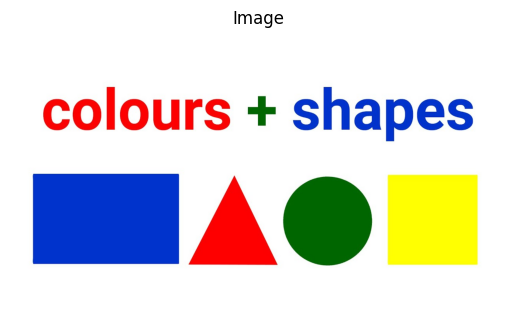

In [9]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.signal as sg

from PIL import Image 
import requests

# load image from url
url = 'https://i.ytimg.com/vi/BqKXHIRwGbs/maxresdefault.jpg'
resp = requests.get(url, stream=True).raw
img = Image.open(resp)

# ensure image is np.array
img = np.array(img)

# plt origin image 
plt.title("Image")
plt.imshow(img)
plt.axis('off')
plt.show()

Image Max Value: 255 Image Min Value: 0


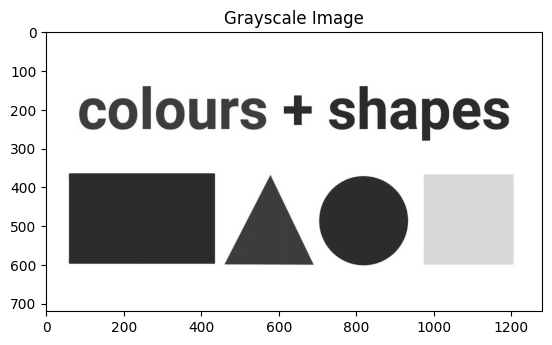

Image Max Value: 1050.6000000000001 Image Min Value: -1050.6000000000001
Image Max Value: 1050.6000000000004 Image Min Value: -1050.6000000000001
Image Max Value: 255.0 Image Min Value: 0.0
Image Max Value: 255.0 Image Min Value: 0.0


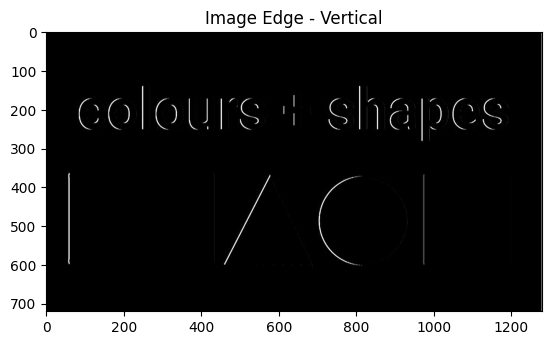

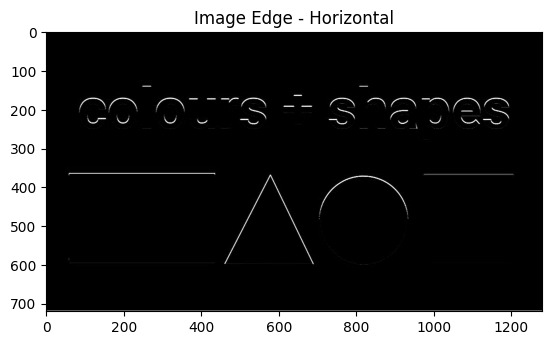

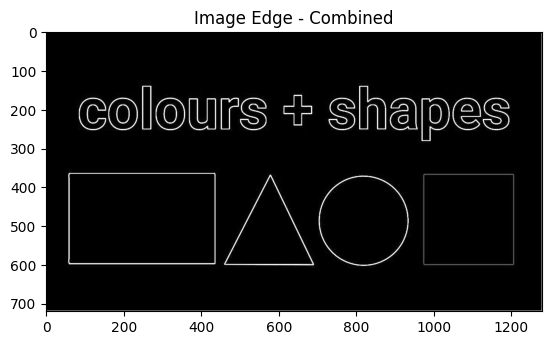

In [15]:
# increase data precision 
img = img.astype(np.int16)
print('Image Max Value:', np.amax(img), 'Image Min Value:', np.amin(img))


#convert from colour to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
  
img_gray = rgb2gray(img)

#plot grayscale image
plt.title("Grayscale Image")
plt.imshow(img_gray, cmap='gray')
plt.show()

#two kernels
sobel_x = np.array([[-1, 0, 1], 
                    [-2, 0, 2], 
                    [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1], 
                    [0, 0, 0], 
                    [1, 2, 1]])
#perform 2d convolution
img_edge_x = sg.convolve(img_gray, sobel_x, mode='same')
img_edge_y = sg.convolve(img_gray, sobel_y, mode='same')

print('Image Max Value:', np.amax(img_edge_x), 'Image Min Value:', np.amin(img_edge_x))
print('Image Max Value:', np.amax(img_edge_y), 'Image Min Value:', np.amin(img_edge_y))


#combine images
img_edge = (img_edge_x**2 + img_edge_y**2)**.5

#normalize images
img_edge_x[img_edge_x > 255] = 255
img_edge_x[img_edge_x < 0] = 0

img_edge_y[img_edge_y > 255] = 255
img_edge_y[img_edge_y < 0] = 0

img_edge[img_edge > 255] = 255
img_edge[img_edge < 0] = 0


print('Image Max Value:', np.amax(img_edge_x), 'Image Min Value:', np.amin(img_edge_x))
print('Image Max Value:', np.amax(img_edge_y), 'Image Min Value:', np.amin(img_edge_y))

#return to image format
img_edge_x = img_edge_x.astype(np.uint8)
img_edge_y = img_edge_y.astype(np.uint8)
img_edge = img_edge.astype(np.uint8)

#plot results of convolution in x, and y
plt.title("Image Edge - Vertical")
plt.imshow(img_edge_x, cmap='gray')
plt.show()

plt.title("Image Edge - Horizontal")
plt.imshow(img_edge_y, cmap='gray')
plt.show()

plt.title("Image Edge - Combined")
plt.imshow(img_edge, cmap='gray')
plt.show()




In [ ]:
## Here is the simple CNN Model 
import torch 
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # o = ((i-k) + 2p)/s + 1 = 256
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)    # o = ((i-k) + 2p)/s + 1 = 128
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) #   o = ((i-k) + 2p)/s + 1 = 128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) #   o = ((i-k) + 2p)/s + 1 = 128
        self.fc1 = nn.Linear(128 * 32 * 32, 512) # 128 channels, 32 x 32 feature map after pooling
        self.fc2 = nn.Linear(512, 257)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
def get_acc(model, train = False, data_loader=None):
    if train:
        model.train()
    else:
        model.eval()

    correct = 0 
    total = 0

    for imgs, labels in data_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs).to(device)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return correct / total


def dataset_preparation(data_dir, batch_size):
    my_transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(ensure_rgb),
        transforms.ToTensor(),
    ])

    full_dataset = datasets.ImageFolder(data_dir, transform=my_transform)
    
    # 1. Get the indices for all images and their corresponding labels
    indices = list(range(len(full_dataset)))
    labels = full_dataset.targets

    # 2. Perform a stratified split
    train_indices, valid_indices = train_test_split(
        indices,
        test_size=0.2,
        stratify=labels,    # This ensures class proportions are preserved!
        random_state=42     # For reproducibility
    )

    # 3. Create Subsets
    train_dataset = Subset(full_dataset, train_indices)
    valid_dataset = Subset(full_dataset, valid_indices)

    # 4. Dataloaders
    pin_memory = True if device.type == 'cuda' else False
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, 
        num_workers=0, pin_memory=pin_memory
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=False, 
        num_workers=0, pin_memory=pin_memory
    )

    return train_loader, valid_loader


def train(model, data_dir, lr ,batch_size = 64, num_epochs=1):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("in dataset preparation")
    train_loader, valid_loader = dataset_preparation(data_dir, batch_size)
    print("dataset preparation done")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)


    iters, losses, train_acc, val_acc = [], [], [], []
    # training 

    n = 0 # number of iterations

    train_acc_iter = 0
    val_acc_iter = 0
    for epoch in range(num_epochs):
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(imgs).to(device)
            loss = criterion(outputs, labels)

            # backward pass and optimization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


            # save the current training information

            iters.append(n + epoch * len(train_loader))
            losses.append(loss.item())
            print("Iteration: ", n + epoch * len(train_loader), " Loss: ", loss.item())
            if (n+1) % 150 == 0:
                train_acc_iter = get_acc(model, train=True, data_loader=train_loader)
                val_acc_iter = get_acc(model, train=False, data_loader=valid_loader)
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{n+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
                print("Train Accuracy: ", train_acc_iter)
                print("Validation Accuracy: ", val_acc_iter)
            n += 1

            train_acc.append(train_acc_iter)
            val_acc.append(val_acc_iter)


    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: ", train_acc[-1])
    print("Final Validation Accuracy: ", val_acc[-1])

In [2]:
# Dataset preparation 

from torchvision import datasets, transforms 
from skimage import color
import numpy as np

def ensure_rgb(img):
    return img.convert('RGB')






In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
train(model, "./data/caltech256", lr=0.01, num_epochs=20)

in dataset preparation
dataset preparation done


KeyboardInterrupt: 

## Visualize the kernels ##

In [6]:
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
# Visualize conv1 kernels (i,e filter)
kernels = model.conv1.weight.data.cpu()

print(kernels.shape)

torch.Size([16, 3, 3, 3])


In [10]:
# this line is required if using GPU
kernels = kernels.cpu()

# display first kernel
print(kernels[0], len(kernels))

tensor([[[ 0.0912, -0.0664, -0.1593],
         [ 0.0319, -0.0419,  0.1589],
         [ 0.0786,  0.0557, -0.1034]],

        [[ 0.0761, -0.1746,  0.1634],
         [ 0.0601, -0.0305,  0.0795],
         [-0.0367,  0.1793,  0.1485]],

        [[ 0.1474, -0.0613, -0.0817],
         [ 0.0402, -0.0205, -0.0680],
         [-0.1873,  0.0137,  0.1632]]]) 16


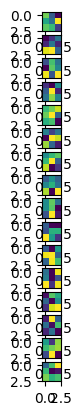

In [11]:
fig, axarr = plt.subplots(kernels.size(0))
for idx in range(kernels.size(0)):
    axarr[idx].imshow(kernels[idx][0])

## Transfer Learning

In [1]:
import torchvision.models

alexNet = torchvision.models.alexnet(pretrained=True)

c:\Users\Admin\Desktop\Project\Python_Env\AI\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\Desktop\Project\Python_Env\AI\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:10<00:00, 22.6MB/s] 


In [2]:
alexNet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [3]:
alexNet.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

(500, 375, 3)


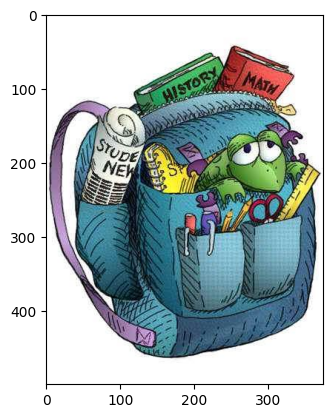

In [4]:
import matplotlib.pyplot as plt
import numpy as np

#laod colour image
img = plt.imread(r".\\data\\caltech256\\003.backpack\\003_0001.jpg")
#img = plt.imread('https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Cat_Director_of_Takagi_village_Muku_Hatojo_Memorial_Library_%283%29.png/800px-Cat_Director_of_Takagi_village_Muku_Hatojo_Memorial_Library_%283%29.png')

img = img[:,:,:3]
print(img.shape)
plt.imshow(img)

In [5]:
import torch

#convert to tensor
x = torch.from_numpy(img) # turn img into a PyTorch tensor
print(x.shape)

x = x.permute(2,0,1)      # move the channel dimension to the beginning
print(x.shape)

torch.Size([500, 375, 3])
torch.Size([3, 500, 375])


C:\Users\Admin\AppData\Local\Temp\ipykernel_11664\4084238813.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  x = torch.from_numpy(img) # turn img into a PyTorch tensor


In [6]:
x = x.reshape([1, 3, 500, 375]) # add a dimension for batching
print(x.shape, x.dtype)

torch.Size([1, 3, 500, 375]) torch.uint8


In [7]:
features = alexNet.features(x/255.0) # normalize the image to [0,1] range
features.shape

torch.Size([1, 256, 14, 10])

The set of numbers in `features` is another way of representing our image `x`. Recall that
our initial image `x` was also represented as a tensor, also a set of numbers representing
pixel intensity. Geometrically speaking, we are using points in a high-dimensional space to
represent the images. in our pixel representation, the axes in this high-dimensional space
were different pixels. In our `features` representation, the axes are not as easily
interpretable.

But we will want to work with the `features` representation, because this representation
makes classification easier. This representation organizes images in a more "useful" and
"semantic" way than pixels.

Let me be more specific:
this set of `features` was trained on image classification. It turns out that
**these features can be useful for performing other image-related tasks as well!**
That is, if we want to perform an image classification task of our own (for example,
classifying cancer biopsies, which is nothing like what AlexNet was trained to do),
we might compute these AlexNet features, and then train a small model on top of those
features. We replace the `classifier` portion of `AlexNet`, but keep its `features`
portion intact.

Somehow, through being trained on one type of image classification problem, AlexNet 
learned something general about representing images for the purposes of other
classification tasks.

### AlexNet First Convolutions

Here is the first convolution of AlexNet, applied to our image

In [8]:
alexNetConv = alexNet.features[0]
x = x/255.0
y = alexNetConv(x)
y.shape

torch.Size([1, 64, 124, 93])

In [9]:
y = y.detach().numpy() # convert to numpy array for visualization
print(y.shape)
y = (y - y.min()) / (y.max() - y.min()) # normalize to [0,1] range
y.shape

(1, 64, 124, 93)


(1, 64, 124, 93)

64
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


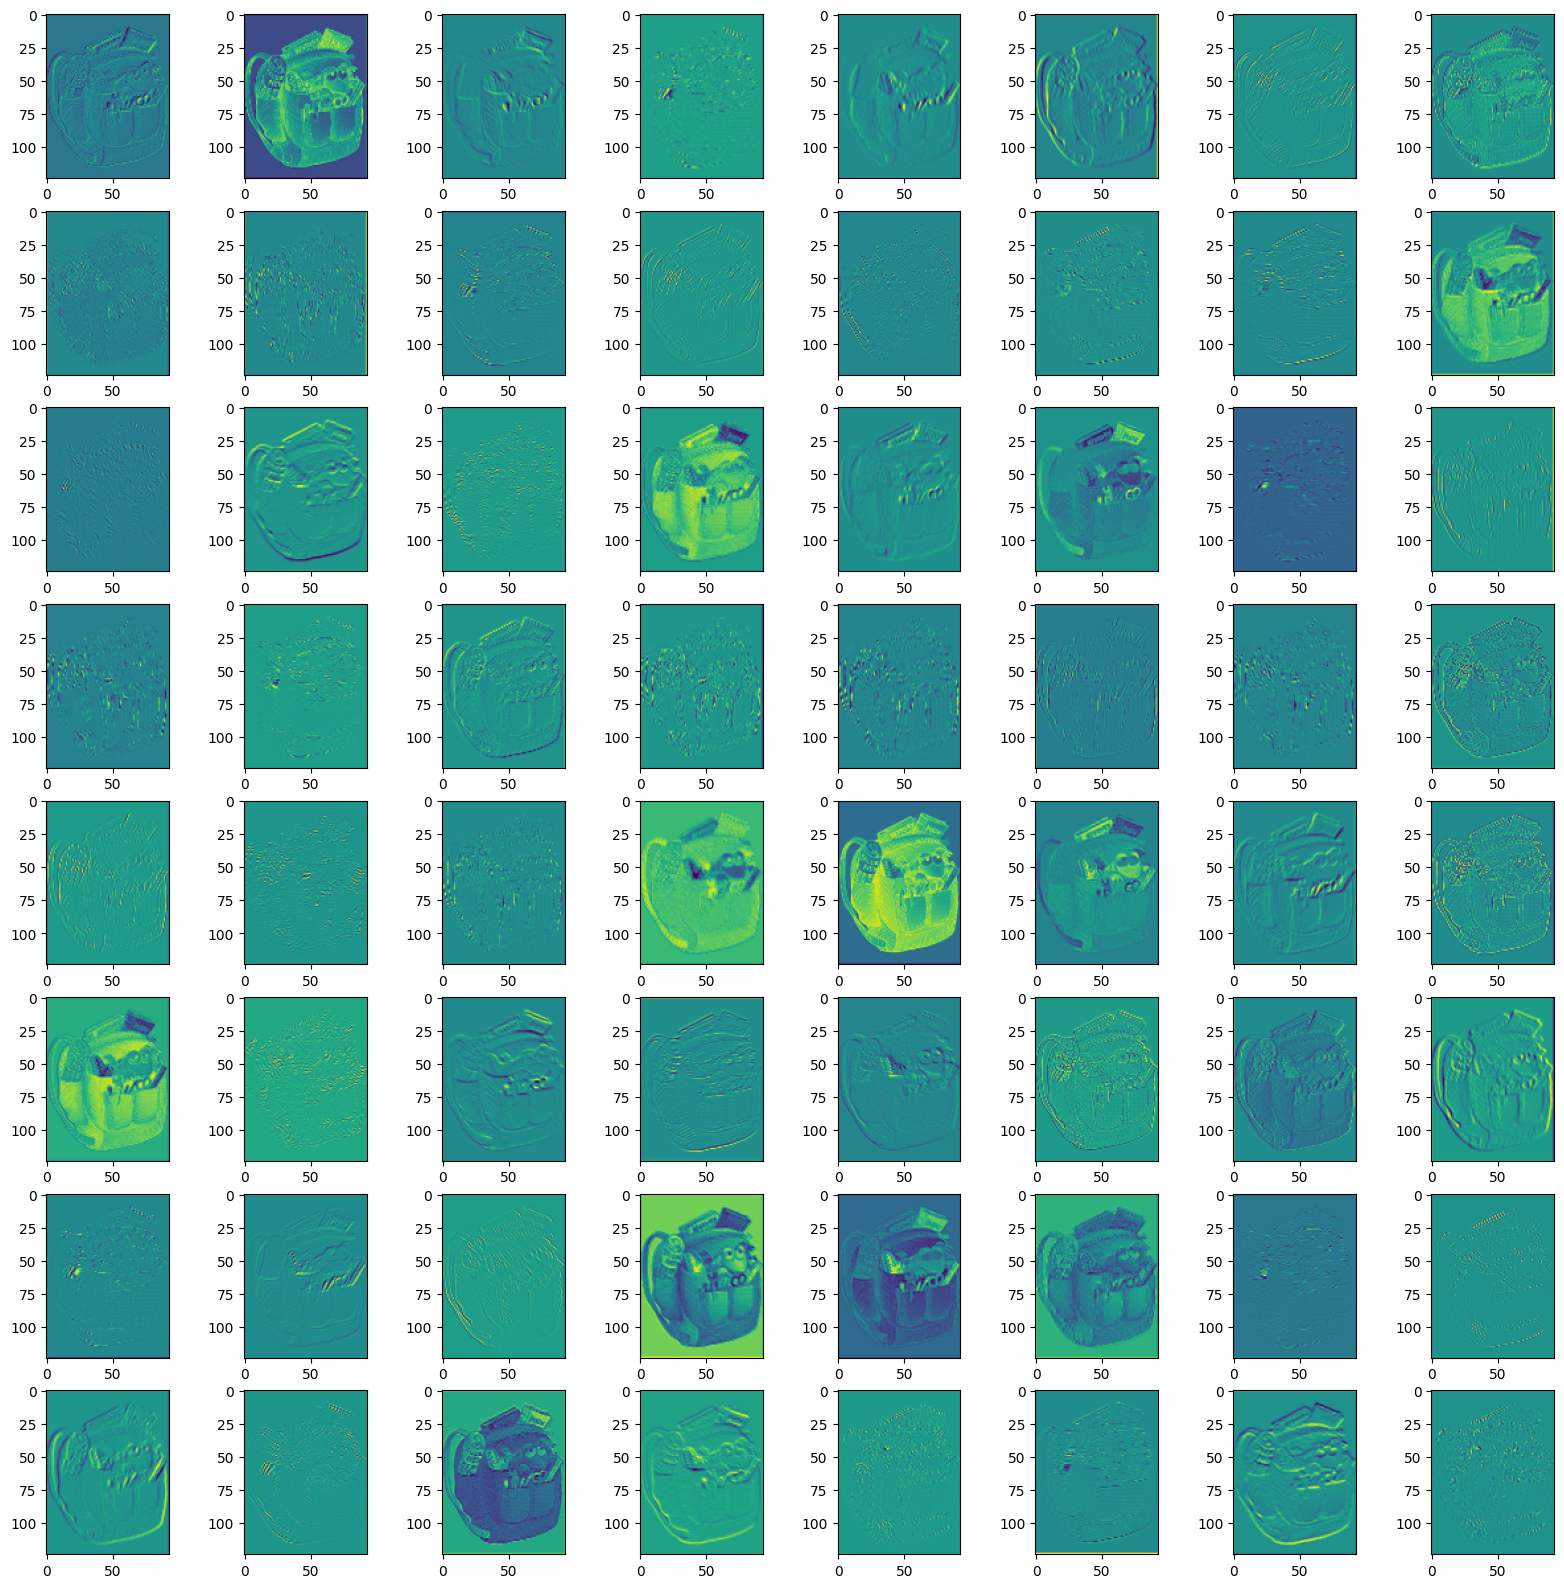

In [10]:
# we can visualize the output of the first convolutional layer by plotting the feature maps

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,20))
print(y.shape[1])
for i in range(y.shape[1]):
    print(i)
    plt.subplot(8,8, i+1)
    plt.imshow(y[0,i])

In [2]:
## Dataset splitting

## Here is the simple CNN Model 
import torch 
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

## Dataset preparation

In [3]:
import time 
import os 
import numpy as np
import torch

import torchvision 
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


data_dir = "./data/caltech256"
def ensure_rgb(img):
    return img.convert('RGB')

my_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.Lambda(ensure_rgb),
    transforms.ToTensor(),
])

full_dataset = datasets.ImageFolder(data_dir, transform=my_transform)
print("Total number of images: ", len(full_dataset))


indices = list(range(len(full_dataset)))
labels = full_dataset.targets

print("Labels: ", labels)


train_indices, valid_indices = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,    # This ensures class proportions are preserved!
    random_state=42     # For reproducibility
)


train_dataset = Subset(full_dataset, train_indices)
valid_dataset = Subset(full_dataset, valid_indices)

len(train_dataset)

Total number of images:  30607
Labels:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

24485

## AlexNet Transfer Learning

In [1]:
## Dataset splitting

## Here is the simple CNN Model 
import torch 
import torch.nn as nn
import torch.nn.functional as F

import time

from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

def ensure_rgb(img):
    return img.convert('RGB')

def dataset_preparation(data_dir, batch_size):
    my_transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(ensure_rgb),
        transforms.ToTensor(),
    ])

    full_dataset = datasets.ImageFolder(data_dir, transform=my_transform)
    
    # 1. Get the indices for all images and their corresponding labels
    indices = list(range(len(full_dataset)))
    labels = full_dataset.targets

    # 2. Perform a stratified split
    train_indices, valid_indices = train_test_split(
        indices,
        test_size=0.2,
        stratify=labels,    # This ensures class proportions are preserved! and this will also ensure the 
                            # the training and validation datasets have the same class distribution as the original dataset, which is important for training a model that generalizes well.
        random_state=42     # For reproducibility
    )

    # 3. Create Subsets
    train_dataset = Subset(full_dataset, train_indices)
    valid_dataset = Subset(full_dataset, valid_indices)

    # 4. Dataloaders
    pin_memory = True if device.type == 'cuda' else False
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, 
        num_workers=0, pin_memory=pin_memory
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=False, 
        num_workers=0, pin_memory=pin_memory
    )

    return train_loader, valid_loader

In [4]:
data_dir = "./data/caltech256"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader, valid_loader = dataset_preparation(data_dir, batch_size=256)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torchvision.models

torch.manual_seed(20)


# obtain one batch of training image

dataiter = iter(train_loader)
images, labels = next(dataiter)

# confirm output from AlexNet feature extraction


alexNet = torchvision.models.alexnet(pretrained=True).to(device)


features = alexNet.features(images.to(device))
print("Feature shape: ", features.shape)

c:\Users\Admin\Desktop\Project\Python_Env\AI\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\Desktop\Project\Python_Env\AI\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature shape:  torch.Size([256, 256, 7, 7])


In [6]:
# ANN Network

class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.fc1 = nn.Linear(256*7*7, 1084)
        self.fc2 = nn.Linear(1084, 512)
        self.fc3 = nn.Linear(512, 257)

    def forward(self, x):
        x = x.view(-1, 256*7*7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## a little side note

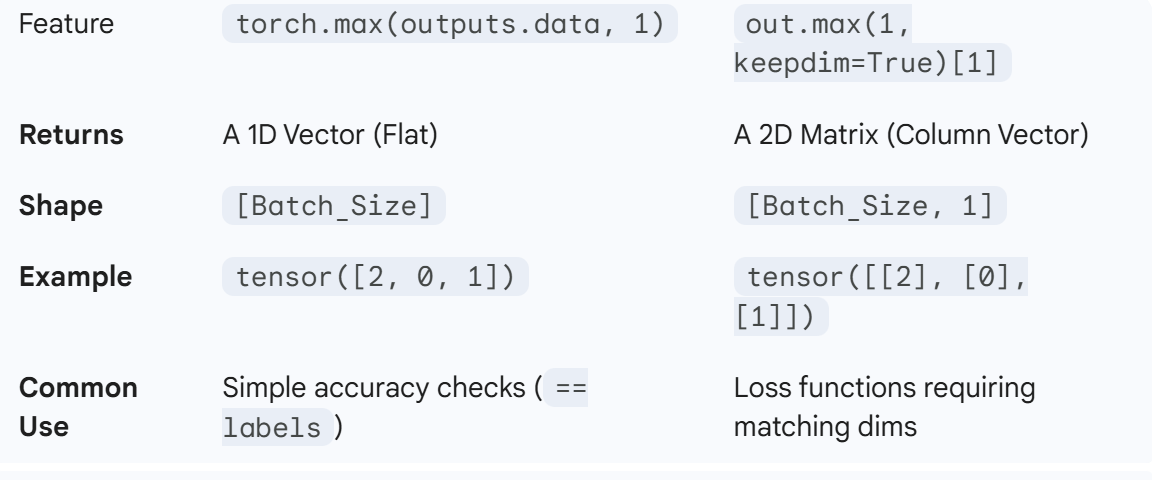

the torch.max(outputs.data,1)

returns a 1D vector flat

shape [Batch_size]

need to use == label for the accuracy check
predicted == labels

==============================================
The out.max(1, keepdim=True)[1]

returns a 2D Matrix (column vecotr)

shape [Batch_size,1]

then you will need to use
mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
for accuracy check 

In [7]:
def get_accuracy(model, train = False, data_loader=None):
    if train:
        model.train()
    else:
        model.eval()
    
    correct = 0
    total = 0

    for imgs, labels in data_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(ALNC(imgs)).to(device)

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

        total += labels.size(0)
        

    return correct / total

def train(model, train_loader, valid_loader, lr=0.01, num_epochs = 1):
    print("Starting training...")
    criterian = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    iteration_count = 0
    print("Beginning epochs...")
    start_time = time.time()
    for epoch in range(num_epochs):

        mini_b = 0
        mini_batch_correct = 0
        mini_batch_total = 0

        for imgs, labels in train_loader:

            if use_cuda and torch.cuda.is_available():
                imgs = imgs.to(device)
                labels = labels.to(device)

            out = model(ALNC(imgs)).to(device)
            loss = criterian(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            print("after optimization step")


            #### Mini-batch accuracy calculation
            pred = out.max(1, keepdim=True)[1]  # get the index of the max log-probability
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = imgs.shape[0]
            train_acc.append(mini_batch_correct / mini_batch_total)

            # save the current training information
            iters.append(iteration_count)
            losses.append(loss.item())
    
            val_acc.append(get_accuracy(model, train=False, data_loader=valid_loader))
            iteration_count += 1
            print("Iteration: ", iteration_count, " Loss: ", loss.item(), " Train Accuracy: ", train_acc[-1], " Validation Accuracy: ", val_acc[-1])
        print("Epoch: ", epoch+1, " Loss: ", loss.item(), " Train Accuracy: ", train_acc[-1], " Validation Accuracy: ", val_acc[-1])

    end_time = time.time()
    
    # plotting 
    plt.title("Training Curve")        
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: ", train_acc[-1])
    print("Final Validation Accuracy: ", val_acc[-1])
    print(f"Training completed in {end_time - start_time:.2f} seconds.")
    return iters, losses, train_acc, val_acc

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_cuda = True if torch.cuda.is_available() else False

model = ANNClassifier()
ALNC = alexNet.features

if use_cuda and torch.cuda.is_available():
    model = model.to(device)
    ALNC = ALNC.to(device)
    print("Model and ALNC moved to GPU.")
else:
    print("Using CPU for training.")

train(model, train_loader, valid_loader, lr=0.02, num_epochs=15)

Model and ALNC moved to GPU.
Starting training...
Beginning epochs...
after optimization step
Iteration:  1  Loss:  5.572678565979004  Train Accuracy:  0.0  Validation Accuracy:  0.007187193727540019
after optimization step
Iteration:  2  Loss:  5.539800643920898  Train Accuracy:  0.0078125  Validation Accuracy:  0.01633453119895459
after optimization step
Iteration:  3  Loss:  5.539687633514404  Train Accuracy:  0.02734375  Validation Accuracy:  0.018784710878797777
after optimization step
Iteration:  4  Loss:  5.525077819824219  Train Accuracy:  0.0234375  Validation Accuracy:  0.021724926494609605
after optimization step
Iteration:  5  Loss:  5.524012088775635  Train Accuracy:  0.01171875  Validation Accuracy:  0.034465860829794186
after optimization step
Iteration:  6  Loss:  5.498291492462158  Train Accuracy:  0.04296875  Validation Accuracy:  0.050473701404769686
after optimization step
Iteration:  7  Loss:  5.491548538208008  Train Accuracy:  0.0625  Validation Accuracy:  0.0591

KeyboardInterrupt: 

## Pytorch Online Example

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, input):
        # Convolution layer C1: 1 input image channel, 6 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a Tensor with size (N, 6, 28, 28), where N is the size of the batch
        c1 = F.relu(self.conv1(input))
        # Subsampling layer S2: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 6, 14, 14) Tensor
        s2 = F.max_pool2d(c1, (2, 2))
        # Convolution layer C3: 6 input channels, 16 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a (N, 16, 10, 10) Tensor
        c3 = F.relu(self.conv2(s2))
        # Subsampling layer S4: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 16, 5, 5) Tensor
        s4 = F.max_pool2d(c3, 2)   # it is also a shorthand description for F.max_pool2d(c3, (2, 2))
        
        # Flatten operation: purely functional, outputs a (N, 400) Tensor
        s4 = torch.flatten(s4, 1)
        # Fully connected layer F5: (N, 400) Tensor input,
        # and outputs a (N, 120) Tensor, it uses RELU activation function
        f5 = F.relu(self.fc1(s4))
        # Fully connected layer F6: (N, 120) Tensor input,
        # and outputs a (N, 84) Tensor, it uses RELU activation function
        f6 = F.relu(self.fc2(f5))
        # Fully connected layer OUTPUT: (N, 84) Tensor input, and
        # outputs a (N, 10) Tensor
        output = self.fc3(f6)
        return output


net = Net()
print(net)